# Treating data from Monitoring Panel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Reading data

In [7]:
df_municipal = pd.read_csv("data/output/df_ts_monitoring_panel_imported_municipal.csv")
df_municipal.data = pd.to_datetime(df_municipal.data, infer_datetime_format=True)

In [14]:
df_national = pd.read_csv("data/output/df_ts_monitoring_panel_imported_national.csv")
df_national.data = pd.to_datetime(df_national.data, infer_datetime_format=True)

## Describing data

### Municipal

In [6]:
df_municipal.data.min()

Timestamp('2020-03-27 00:00:00')

In [5]:
df_municipal.data.max()

Timestamp('2022-12-31 00:00:00')

In [8]:
df_municipal.data.unique().shape

(1010,)

In [9]:
df_municipal.groupby('CODIGO_MUNICIPIO_7').count().shape[0]

5570

In [10]:
df_municipal.casosNovos.sum()

36260705

In [12]:
df_municipal[df_municipal.data==df_municipal.data.max()].casosAcumulado.sum()

36260705.0

In [11]:
df_municipal.obitosNovos.sum()

692507

### National

In [15]:
df_national.data.min()

Timestamp('2020-02-25 00:00:00')

In [16]:
df_national.data.max()

Timestamp('2022-12-31 00:00:00')

In [17]:
df_national.data.unique().shape

(1041,)

In [18]:
df_national.casosNovos.sum()

36331281

In [19]:
df_national.obitosNovos.sum()

693853

## Anomalies

### Missing data

In [20]:
df_municipal.isnull().any()

data                  False
estado                False
municipio             False
CODIGO_MUNICIPIO_6    False
obitosNovos           False
obitosAcumulado       False
casosNovos            False
casosAcumulado        False
CODIGO_MUNICIPIO_7    False
dtype: bool

### Noised data

### Municipal

In [22]:
df_municipal[df_municipal.casosNovos < 0].shape[0]

63893

In [23]:
df_municipal[df_municipal.obitosNovos < 0].shape[0]

15672

### National

In [26]:
df_national = df_national.sort_values('data')

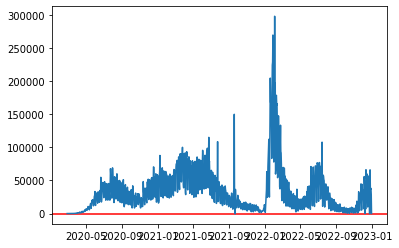

In [27]:
plt.axhline(0, c='red')
plt.plot(df_national.data, df_national.casosNovos)
plt.show()

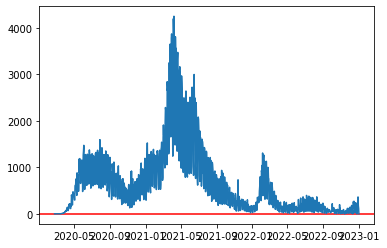

In [28]:
plt.axhline(0, c='red')
plt.plot(df_national.data, df_national.obitosNovos)
plt.show()

### Seasonality

In [29]:
# Group data by day of the week
df_national['day_of_week'] = df_national.data.dt.dayofweek

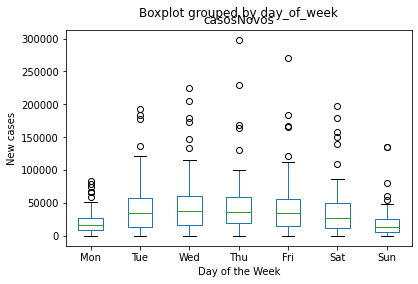

In [30]:
df_national.boxplot(column='casosNovos', by='day_of_week', grid=False)

# Customize plot
plt.xlabel('Day of the Week')
plt.ylabel('New cases')
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Show the plot
plt.show()

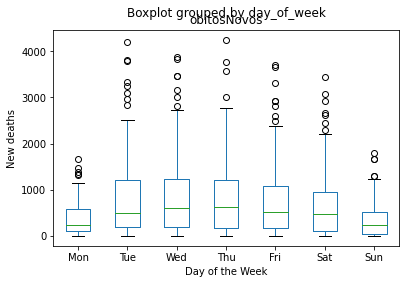

In [31]:
df_national.boxplot(column='obitosNovos', by='day_of_week', grid=False)

# Customize plot
plt.xlabel('Day of the Week')
plt.ylabel('New deaths')
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Show the plot
plt.show()

## Treatment

### Municipal

In [32]:
df_municipal

,data,estado,municipio,CODIGO_MUNICIPIO_6,obitosNovos,obitosAcumulado,casosNovos,casosAcumulado,CODIGO_MUNICIPIO_7
0,2020-03-27,RO,Alta Floresta D'Oeste,110001,0,0,0,0.0,1100015
1,2020-03-28,RO,Alta Floresta D'Oeste,110001,0,0,0,0.0,1100015
2,2020-03-29,RO,Alta Floresta D'Oeste,110001,0,0,0,0.0,1100015
3,2020-03-30,RO,Alta Floresta D'Oeste,110001,0,0,0,0.0,1100015
4,2020-03-31,RO,Alta Floresta D'Oeste,110001,0,0,0,0.0,1100015
...,...,...,...,...,...,...,...,...,...
5625695,2021-06-26,DF,Brasília,530010,12,9184,786,427432.0,5300108
5625696,2021-06-27,DF,Brasília,530010,9,9193,920,428352.0,5300108
5625697,2021-06-28,DF,Brasília,530010,13,9206,666,429018.0,5300108
5625698,2021-06-29,DF,Brasília,530010,26,9232,618,429636.0,5300108


In [34]:
date_range = pd.date_range(start=df_municipal['data'].min(), end=df_municipal['data'].max(), freq='D')

In [35]:
df_municipal = df_municipal.groupby('CODIGO_MUNICIPIO_7').apply(lambda group: group.set_index('data').reindex(date_range))

In [36]:
df_municipal = df_municipal.drop(columns=['municipio', 'CODIGO_MUNICIPIO_7', 'estado'])

In [37]:
df_municipal = df_municipal.reset_index().rename(columns={'level_1': 'data'}).fillna(0)

In [38]:
df_municipal['data'] = pd.to_datetime(df_municipal['data'])

In [39]:
# Sort the DataFrame by 'CODIGO_MUNICIPIO_7' and 'DATA'
df_municipal = df_municipal.sort_values(by=['CODIGO_MUNICIPIO_7', 'data'])

In [40]:
# Calculate the 7-day moving average
window_size = 7
df_municipal['CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df_municipal.groupby('CODIGO_MUNICIPIO_7')['casosNovos'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)

In [41]:
df_municipal['OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df_municipal.groupby('CODIGO_MUNICIPIO_7')['obitosNovos'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)

### National

In [42]:
df_national['CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df_national['casosNovos'].rolling(window=window_size, min_periods=1).mean()
df_national['OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df_national['obitosNovos'].rolling(window=window_size, min_periods=1).mean()

## Saving data

In [43]:
df_municipal.to_csv('data/output/df_ts_monitoring_panel_treated_municipal.csv', index=False)

In [44]:
df_municipal.shape

(5625700, 9)

In [45]:
df_municipal.head()

,CODIGO_MUNICIPIO_7,data,CODIGO_MUNICIPIO_6,obitosNovos,obitosAcumulado,casosNovos,casosAcumulado,CASOS_NOVOS_MEDIA_MOVEL_7_DIAS,OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS
0,1100015,2020-03-27,110001,0,0,0,0.0,0.0,0.0
1,1100015,2020-03-28,110001,0,0,0,0.0,0.0,0.0
2,1100015,2020-03-29,110001,0,0,0,0.0,0.0,0.0
3,1100015,2020-03-30,110001,0,0,0,0.0,0.0,0.0
4,1100015,2020-03-31,110001,0,0,0,0.0,0.0,0.0


In [46]:
df_national.to_csv('data/output/df_ts_monitoring_panel_treated_national.csv', index=False)

In [47]:
df_national.shape

(1041, 11)

In [48]:
df_national.head()

,data,estado,municipio,CODIGO_MUNICIPIO_6,obitosNovos,obitosAcumulado,casosNovos,casosAcumulado,day_of_week,CASOS_NOVOS_MEDIA_MOVEL_7_DIAS,OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS
0,2020-02-25,NaN,NaN,NaN,0,0,0,0.0,1,0.000000,0.0
1,2020-02-26,NaN,NaN,NaN,0,0,1,1.0,2,0.500000,0.0
2,2020-02-27,NaN,NaN,NaN,0,0,0,1.0,3,0.333333,0.0
3,2020-02-28,NaN,NaN,NaN,0,0,0,1.0,4,0.250000,0.0
4,2020-02-29,NaN,NaN,NaN,0,0,1,2.0,5,0.400000,0.0
